In [40]:
import numpy as np
import scipy as sc

from src.Tools import portfolio_metrics
from qiskit_src.ansatz import CP_QAOA, qubo_cost
from qiskit_src.tools import get_qubo, min_cost_partition

In [66]:
N=10
k=5
seed=0
alpha=0.001
layers=4
max_iter=10000

w_z_phase = False
w_next_nearest_neighbors = False
w_evenly_distributed = True


In [67]:
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
min_state_str = ''.join([str(_) for _ in min_state])
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances,
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)

In [72]:
ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 QUBO_matrix=Q,
                 QUBO_offset=offset,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_evenly_distributed_start_x=w_evenly_distributed,
                 with_z_phase=w_z_phase)

# Initial guess for parameters (gamma, beta) of circuit
theta_min, theta_max = -np.pi, np.pi
N_xx_yy_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_xx_yy_angles += layers * (N - 2)
if w_z_phase:
    N_xx_yy_angles += N * layers
#theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_xx_yy_angles)
theta_i = np.random.normal(loc=0, scale=1, size=N_xx_yy_angles)

_available_methods_ = ['COBYLA', 'Nelder-Mead']
_method_idx_ = 0

res = sc.optimize.minimize(fun=ansatz.get_cost, x0=theta_i,
                           method=_available_methods_[_method_idx_],
                           tol=1e-3,
                           options={'disp': False, 'maxiter': max_iter})

_dict_ = ansatz.get_state_probabilities(angles=res.x, flip_states=False)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.22962894731542727
        x: [-7.850e-01  1.429e+00 ... -2.351e+00  4.051e-01]
      nit: 34
      jac: [-6.634e-06  3.886e-08 ...  2.253e-05  1.381e-05]
     nfev: 3172
     njev: 61
 hess_inv: <51x51 LbfgsInvHessProduct with dtype=float64>

In [73]:
res.status

Text(0.5, 0, 'Nr. Iteration')

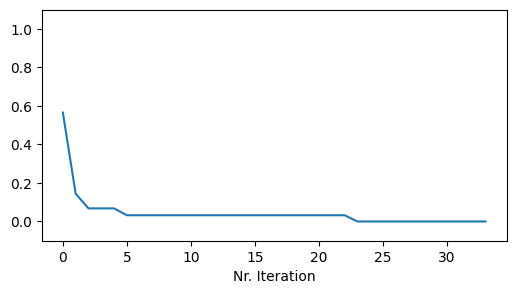

In [74]:
best_state = list(_dict_.keys())[np.argmax(list(_dict_.values()))]
best_state, _dict_[best_state] 

In [76]:
opt_cost = qubo_cost(min_state.astype(np.float64),Q)+offset
opt_cost

7.85068687757458e-15

In [59]:
found_cost = qubo_cost(np.array([float(_) for _ in best_state]).astype(np.float64), Q) + offset
found_cost 

-3.724561129862593

In [60]:
print(f'Normalized cost: {abs(found_cost - min_cost) / abs(max_cost - min_cost)}')

-3.1857426923990175

In [61]:
abs(found_cost - min_cost)

Normalized cost: 0.3663587217098206


In [62]:
found_cost == min_cost

0.5388184374635872

False